In [1]:
# %load test_dagm2007.py
import os
from PIL import Image

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

from dagmm import DAGMM

import matplotlib.pyplot as plt


In [2]:
root = './data/Class1/'
fnames = os.listdir(root)
np_imgs = []

for fname in fnames:
    im = Image.open(os.path.join(root, fname))
    np_imgs.append(np.asarray(im))
np_imgs = np.asarray(np_imgs)
np_imgs = np_imgs.astype(np.float64)

np_imgs_mean = np_imgs.mean(axis=0)
np_imgs_var = np_imgs.var(axis=0)
np_imgs = (np_imgs - np_imgs_mean) / np.sqrt(np_imgs_var)
np_imgs = np_imgs.astype(np.float64)

np_imgs = np_imgs.reshape(-1, 512*512)

np_imgs = np_imgs[:, :512]

In [3]:
x_train = np_imgs[:4*len(np_imgs)//5]

x_test = np_imgs[4*len(np_imgs)//5:]
n_abn = 100
np.random.seed(0)
# x_test[:n_abn] = np.random.uniform(size=(n_abn, 512)) + 10
x_test[:n_abn] = np.sin(np.linspace(-512*np.pi, 512*np.pi, n_abn*512)).reshape(n_abn, 512) + 10
# x_test[:n_abn] = np.ones(shape=(n_abn, 120)) * 10

# ミニバッチ数の変化させた時のテスト
ミニバッチ数が1の場合は常にエラーが起こる。
PyTorchのヤツと同じアーキテクチャ


## ミニバッチ数が１

In [4]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=1
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-196362628edf>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=1\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train[np.random.permutation(len(x_train))])\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


## ミニバッチ数が20

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
(200,)


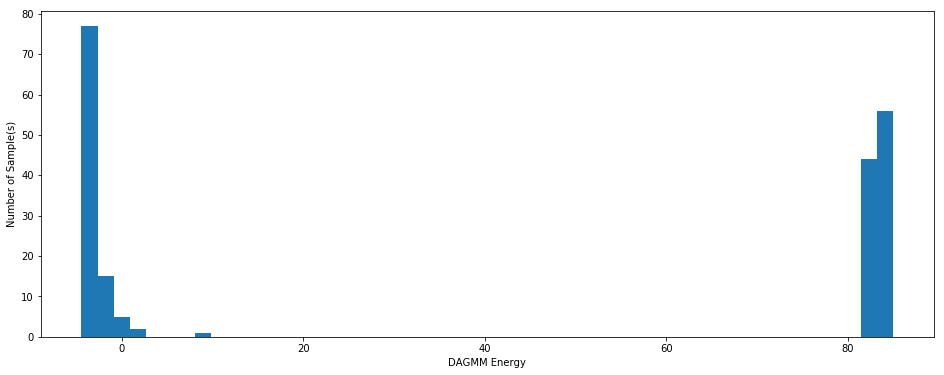

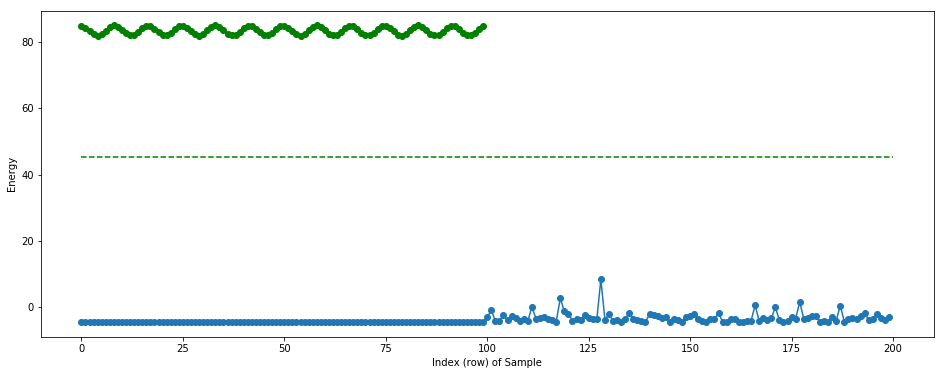

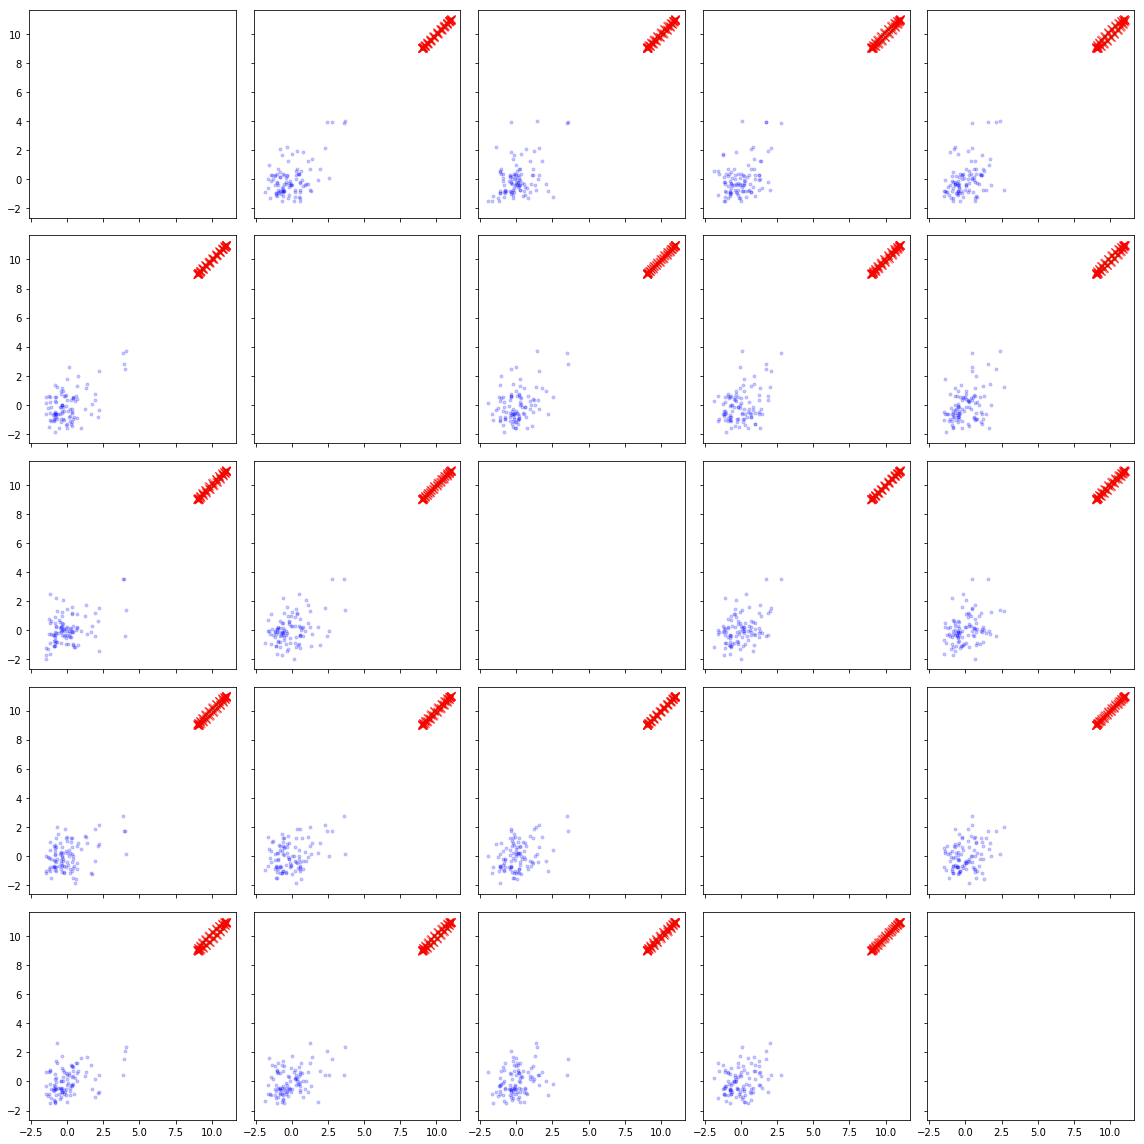

Precision: TP / (TP + FP):  1.0
Recall: TP / (TP + FN):  1.0
Accuracy:  1.0
CPU times: user 9.77 s, sys: 2.27 s, total: 12 s
Wall time: 7.11 s


In [6]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=20
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

## ミニバッチ数が100

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
(200,)


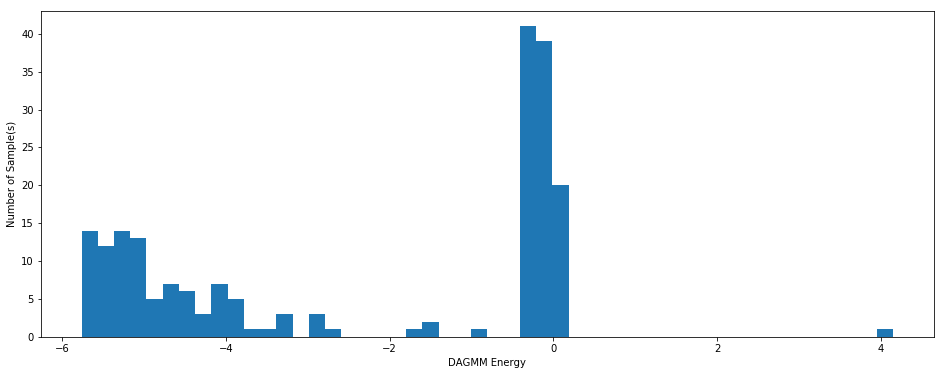

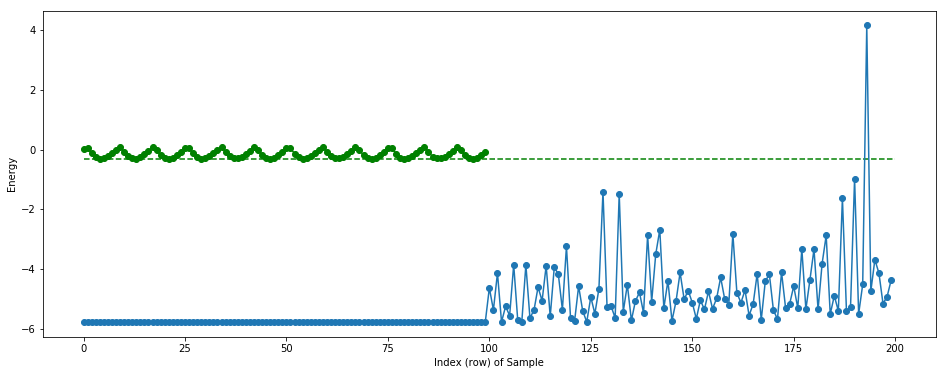

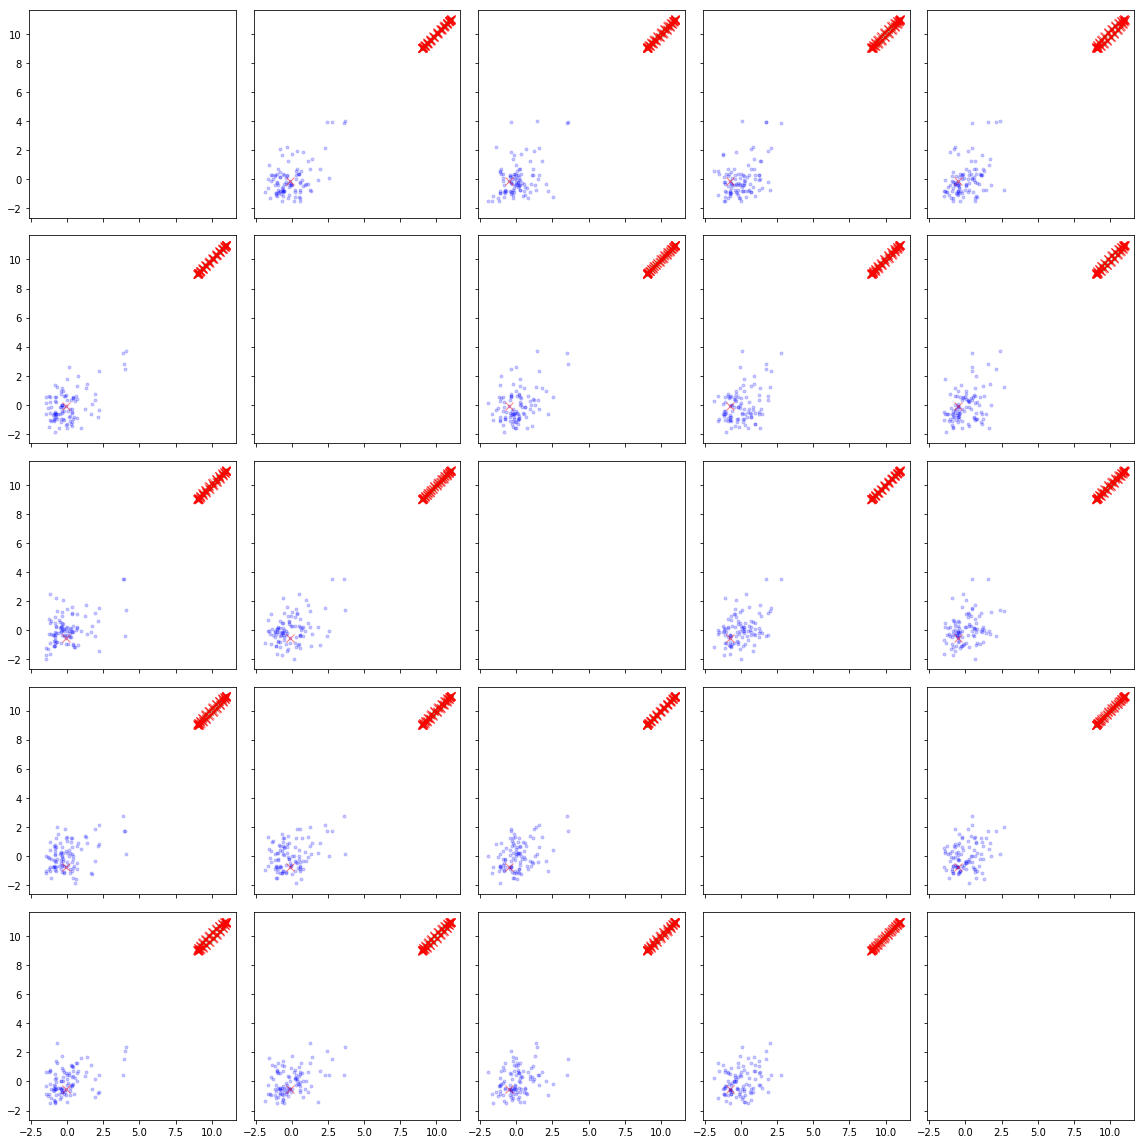

Precision: TP / (TP + FP):  0.99
Recall: TP / (TP + FN):  0.99
Accuracy:  0.99
CPU times: user 6.05 s, sys: 2 s, total: 8.05 s
Wall time: 5.14 s


In [5]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=100
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

# データセットをおかしくする
全部１のデータセット

平均引きによって０になる箇所が絶対におこる

## 期待する結果 絶対にエラーが起きる

In [7]:
x_train = np.ones_like(np_imgs[:4*len(np_imgs)//5])
x_test = np.ones_like(np_imgs[4*len(np_imgs)//5:])
n_abn = 100
np.random.seed(0)
# x_test[:n_abn] = np.random.uniform(size=(n_abn, 512)) + 10
x_test[:n_abn] = np.sin(np.linspace(-512*np.pi, 512*np.pi, n_abn*512)).reshape(n_abn, 512) + 10
# x_test[:n_abn] = np.ones(shape=(n_abn, 120)) * 10

## ミニバッチ数が1

In [8]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=1
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-196362628edf>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=1\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train[np.random.permutation(len(x_train))])\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


## ミニバッチ数が20

In [10]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=20
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c8e85c3aec7e>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=20\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train[np.random.permutation(len(x_train))])\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


## ミニバッチ数が100

In [9]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=100
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train[np.random.permutation(len(x_train))])

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 800
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-3be883762ecd>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=100\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train[np.random.permutation(len(x_train))])\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


# データセットをおかしくする
２０バッチサイズの場合

ミニバッチ内が同じデータになるようなデータセット

平均引きによって０になる箇所が絶対におこる

## 期待する結果 ミニバッチ数が２０だとエラーが起きる

In [20]:
x_train = np.ones_like(np_imgs[:4*len(np_imgs)//5])
A = np.arange(100)[:, np.newaxis] * np.ones((1, 512))
A = A.reshape(-1, 512)
print(A.shape)
x_train = np.repeat(A, repeats=20, axis=0)

x_test = x_train[:200].copy()
n_abn = 100
np.random.seed(0)
x_test[:n_abn] = np.random.uniform(size=(n_abn, 512)) + 10
# x_test[:n_abn] = np.sin(np.linspace(-512*np.pi, 512*np.pi, n_abn*512)).reshape(n_abn, 512) + 10
# x_test[:n_abn] = np.ones(shape=(n_abn, 120)) * 10

(100, 512)


In [26]:
for i in range(100):
    if np.sum(x_train[i*20:(i+1)*20] == i) == 10240:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## ミニバッチ数が1

In [29]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=1
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train)

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 2000
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-bac3b7780d0d>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=1\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train)\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


## ミニバッチ数が20

In [28]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=20
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train)

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))

train size 2000
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]

Caused by op 'GMM_1/Cholesky', defined at:
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/genta/.pyenv/versions/3.6.3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-cd0b61e0d9a8>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\nmodel_dagmm = DAGMM(\n    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,\n    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n    epoch_size=25, minibatch_size=20\n)\n\n# model_dagmm = DAGMM(\n#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,\n#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,\n#     epoch_size=50, minibatch_size=100\n# )\n\nprint(\'train size\', len(x_train))\nmodel_dagmm.fit(x_train)\n\ndata = x_test\nenergy = model_dagmm.predict(data)\n\nprint(energy.shape)\n\nplt.figure(figsize=[16,6])\nhistinfo = plt.hist(energy, bins=50)\nplt.xlabel("DAGMM Energy")\nplt.ylabel("Number of Sample(s)")\n# plt.savefig("./dagm2007_class1_energy_hist.png")\nplt.show()\n\nthreshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))\n\nplt.figure(figsize=[16,6])\nplt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")\nplt.plot(energy[:n_abn], "o-", c=\'g\')\nplt.hlines(threshold, 0, len(x_test), \'g\', linestyles=\'dashed\')\nplt.xlabel("Index (row) of Sample")\nplt.ylabel("Energy")\n# plt.savefig("./dagm2007_class1_energy.png")\nplt.show()\n\nfig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)\nplt.subplots_adjust(wspace=0.05, hspace=0.05)\n\nfor row in range(5):\n    for col in range(5):\n        ax = axes[row, col]\n        if row != col:\n            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c=\'b\', alpha=0.2)\n            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c=\'g\', alpha=0.2)\n            ano_index = np.arange(len(energy))[energy > threshold]\n            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)\nplt.tight_layout()\n# plt.savefig("./dagm2007_scatter.png")\nplt.show()\n\ntn = 0\nfn = 0\nfor index in np.arange(len(energy))[energy > threshold]:\n    if index < n_abn:\n        tn += 1\n    else:\n        fn += 1\ntp = 0\nfp = 0\nfor index in np.arange(len(energy))[energy <= threshold]:\n    if index >= n_abn:\n        tp += 1\n    else:\n        fp += 1\n    \nprint(\'Precision: TP / (TP + FP): \', tp / (tp + fp))\nprint(\'Recall: TP / (TP + FN): \', tp / (tp + fn))\nprint(\'Accuracy: \', (tn+tp)/len(energy))\n')
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "/home/genta/github/DAGMM/dagmm/dagmm.py", line 123, in fit
    energy = self.gmm.energy(z)
  File "/home/genta/github/DAGMM/dagmm/gmm.py", line 108, in energy
    self.L = tf.cholesky(self.sigma + self.min_vals[None,:,:])
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GMM_1/Cholesky (defined at /home/genta/github/DAGMM/dagmm/gmm.py:108)  = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM_1/add)]]


## ミニバッチ数が100

train size 2000
Tensor("CompNet/concat_1:0", shape=(?, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(), dtype=float32)
(200,)


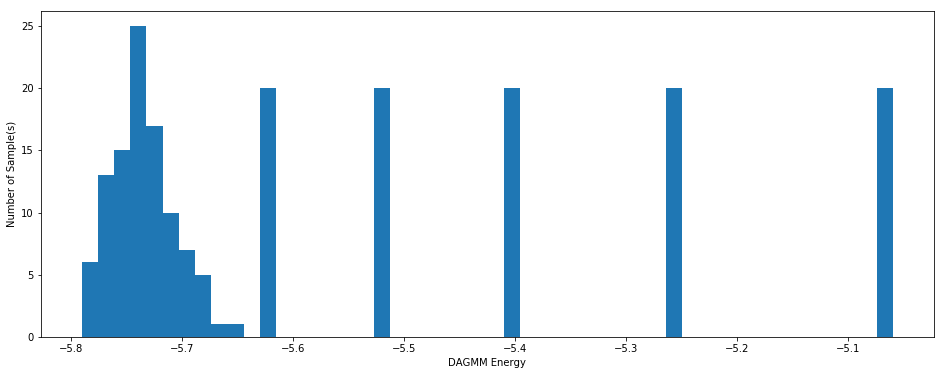

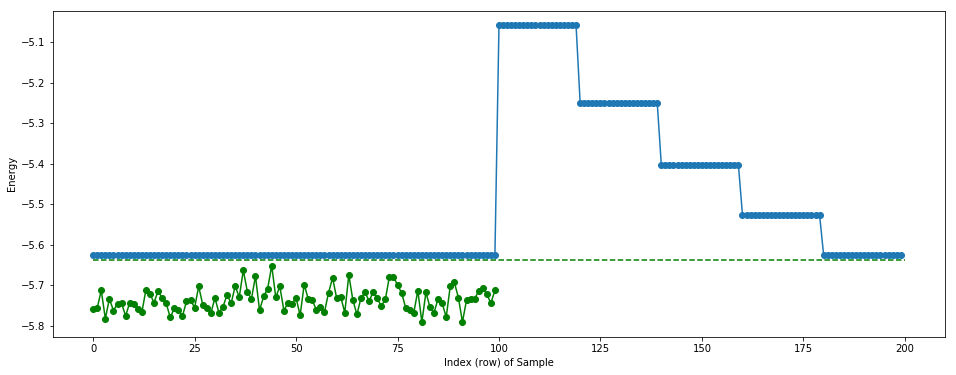

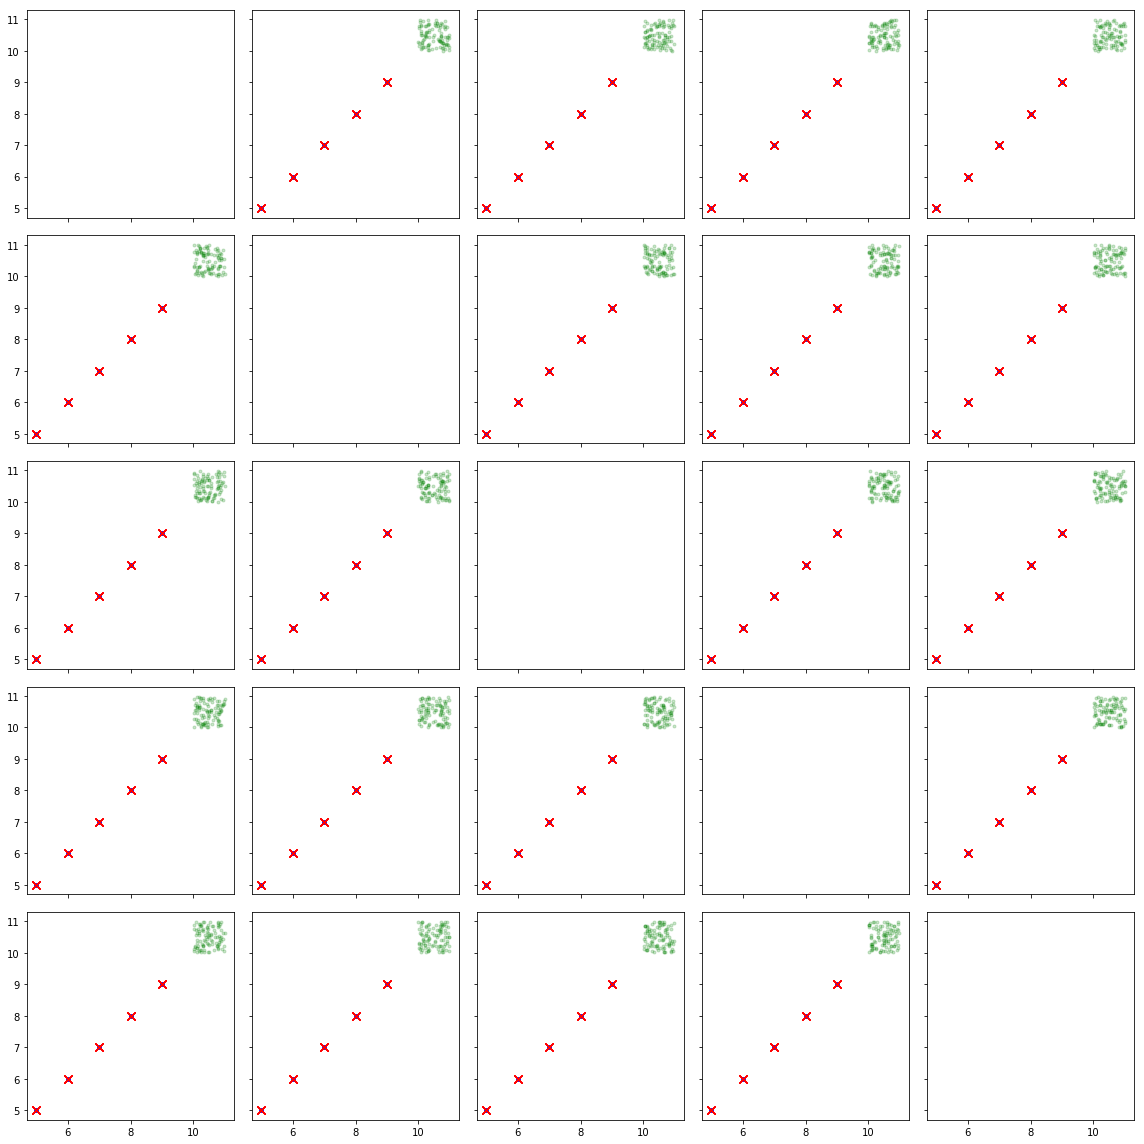

Precision: TP / (TP + FP):  0.0
Recall: TP / (TP + FN):  0.0
Accuracy:  0.0
CPU times: user 7.58 s, sys: 2.01 s, total: 9.59 s
Wall time: 5.87 s


In [30]:
%%time

model_dagmm = DAGMM(
    comp_hiddens=[60,30,10, 1], comp_activation=tf.nn.tanh,
    est_hiddens=[10, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=25, minibatch_size=100
)

# model_dagmm = DAGMM(
#     comp_hiddens=[10, 1], comp_activation=tf.nn.tanh,
#     est_hiddens=[2, 2], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=50, minibatch_size=100
# )

print('train size', len(x_train))
model_dagmm.fit(x_train)

data = x_test
energy = model_dagmm.predict(data)

print(energy.shape)

plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

threshold = np.percentile(energy, 100*(1-n_abn/len(x_test)))

plt.figure(figsize=[16,6])
plt.plot(np.concatenate([np.ones(n_abn)*energy[n_abn:].min(), energy[n_abn:]]), "o-")
plt.plot(energy[:n_abn], "o-", c='g')
plt.hlines(threshold, 0, len(x_test), 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[n_abn:,col], data[n_abn:,row], ".", c='b', alpha=0.2)
            ax.plot(data[:n_abn,col], data[:n_abn,row], ".", c='g', alpha=0.2)
            ano_index = np.arange(len(energy))[energy > threshold]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()

tn = 0
fn = 0
for index in np.arange(len(energy))[energy > threshold]:
    if index < n_abn:
        tn += 1
    else:
        fn += 1
tp = 0
fp = 0
for index in np.arange(len(energy))[energy <= threshold]:
    if index >= n_abn:
        tp += 1
    else:
        fp += 1
    
print('Precision: TP / (TP + FP): ', tp / (tp + fp))
print('Recall: TP / (TP + FN): ', tp / (tp + fn))
print('Accuracy: ', (tn+tp)/len(energy))